In [1]:
import logging
import pyvista as pv

from pointcept.supplemental.utils import *
from pointcept.supplemental.mesh_processing import DataHandler, set_data_root, MeshAnalyser
from pointcept.supplemental.fold_allocation import (
    GridSplitter,
    plot_mesh_folds,
    crop_meshes_per_fold,
    save_fold_meshes
)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

set_data_root("../../data")
label = 'park_row'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dh = DataHandler(label)
dh.ensure_meshes()

01:28:08 - INFO - Label park_row already has extracted meshes.


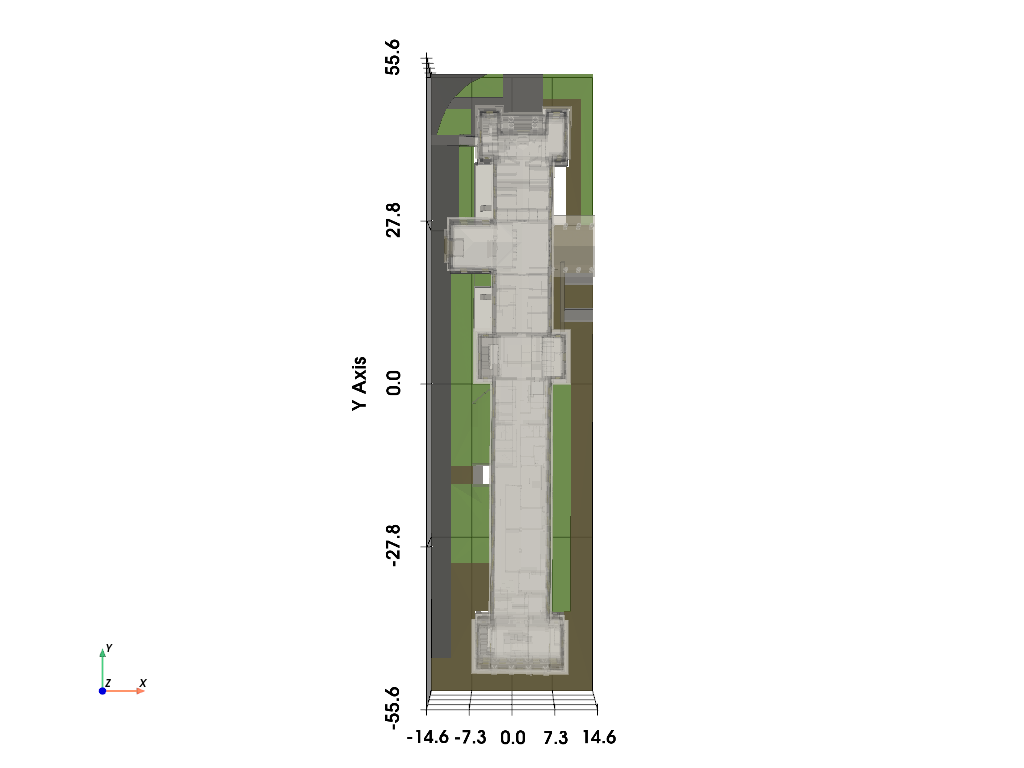

In [3]:
dh.plot_meshes()

In [4]:
analyser = MeshAnalyser(data_handler=dh)

In [5]:
to_exclude = []
pcds = analyser.generate_toy_pcds(resolution=0.15, excluded_categories=to_exclude)

01:28:10 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '5_FOOTPATH', '6_GRASS', '7_COLUMN', '8_DOOR', '9_WINDOW', '10_STAIR', '11_RAILING', '12_RWP', '13_OTHER'].
01:28:10 - INFO - Sampling with resolution 0.15.
01:28:10 - INFO - Number of points after initial sampling: 8870916
01:28:13 - INFO - Number of points after Poisson Disk Sampling: 461770
01:28:13 - INFO - Number of points after initial sampling: 1246176
01:28:14 - INFO - Number of points after Poisson Disk Sampling: 204398
01:28:14 - INFO - Number of points after initial sampling: 1176628
01:28:14 - INFO - Number of points after Poisson Disk Sampling: 65777
01:28:14 - INFO - Number of points after initial sampling: 3485817
01:28:15 - INFO - Number of points after Poisson Disk Sampling: 134444
01:28:15 - INFO - Number of points after initial sampling: 613094
01:28:16 - INFO - Number of points after Poisson Disk Sampling: 104626
01:28:16 - INFO - Number of points after initial s

In [6]:
binning = analyser.evaluate_binning(pcds, x_cell_width=6.0, y_cell_width=6.0)
counts = binning['counts']
x_edges = binning['x_edges']
y_edges = binning['y_edges']

01:28:17 - INFO - Binning is using 5 bins in X and 19 bins in Y based on cell widths of 6.0 and 6.0.


01:28:17 - INFO - New best equality score: 90799.6270 at iteration 1
01:28:17 - INFO - New best equality score: 53066.2975 at iteration 6
01:28:17 - INFO - New best equality score: 52153.3665 at iteration 8
01:28:17 - INFO - New best equality score: 39461.9725 at iteration 14
01:28:17 - INFO - New best equality score: 24260.2266 at iteration 17
01:28:18 - INFO - New best equality score: 17422.4333 at iteration 282
01:28:19 - INFO - New best equality score: 17320.6675 at iteration 433
01:28:19 - INFO - Number of unique seed cell configurations = 499


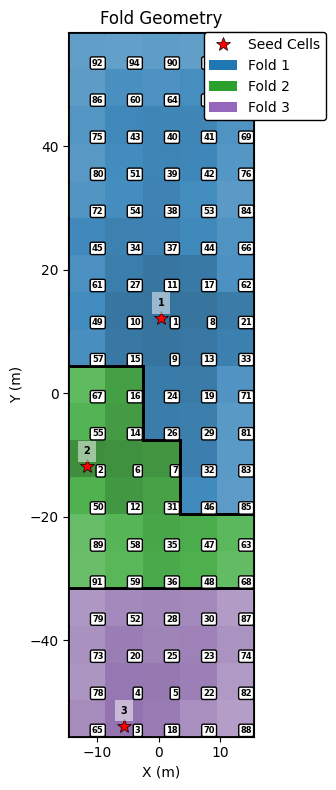

Iteration: 433

Fold Summaries:

Fold 1:
  Intended total counts: 653218.80
  Actual total counts: 646996.0
  Category Counts:
    1_WALL: 283648.0 (61.43% of total 1_WALL)
    2_FLOOR: 123191.0 (60.27% of total 2_FLOOR)
    3_ROOF: 45111.0 (68.58% of total 3_ROOF)
    4_CEILING: 72343.0 (53.81% of total 4_CEILING)
    5_FOOTPATH: 55131.0 (52.69% of total 5_FOOTPATH)
    6_GRASS: 13534.0 (52.09% of total 6_GRASS)
    7_COLUMN: 21869.0 (61.86% of total 7_COLUMN)
    8_DOOR: 10091.0 (70.72% of total 8_DOOR)
    9_WINDOW: 9604.0 (50.73% of total 9_WINDOW)
    10_STAIR: 5714.0 (61.50% of total 10_STAIR)
    11_RAILING: 2737.0 (43.38% of total 11_RAILING)
    12_RWP: 328.0 (39.85% of total 12_RWP)
    13_OTHER: 3695.0 (54.96% of total 13_OTHER)
  Aspect Ratio: 2.60

Fold 2:
  Intended total counts: 217739.60
  Actual total counts: 192992.0
  Category Counts:
    1_WALL: 72887.0 (15.78% of total 1_WALL)
    2_FLOOR: 40219.0 (19.68% of total 2_FLOOR)
    3_ROOF: 11551.0 (17.56% of total 3_ROO

In [7]:
weights = {1: 0.6, 2: 0.2, 3: 0.2}  # Intended area weights: training, evaluation, test
region_counts = {1: 1, 2: 1, 3: 1}
iterations = 500  # Number of iterations to run

# Create an instance of GridSplitter
grid_splitter = GridSplitter(
    counts=counts,
    x_edges=x_edges,
    y_edges=y_edges,
    weights=weights,
    iterations=iterations,
    region_counts=region_counts,
)
grid_splitter.min_percentage_threshold = 4.0

# Run the algorithm
grid_splitter.run()

# Access the best configuration
best_config = grid_splitter.best_configuration

# Plot the result
best_config.plot()

# Print the summary
best_config.print_summary()

01:29:11 - INFO - Fold 1, Region 1: Found 3 rectangles with total perimeter 46


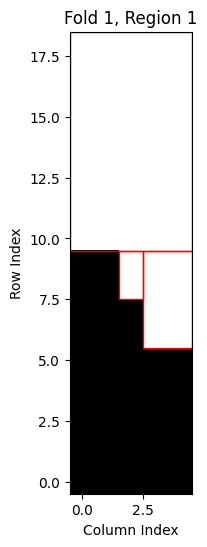

01:29:11 - INFO - Fold 2, Region 2: Found 3 rectangles with total perimeter 30


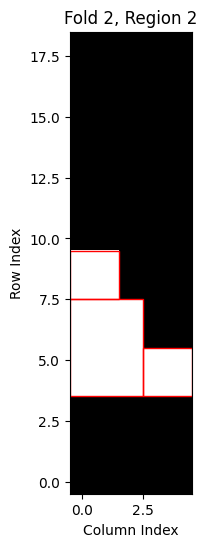

01:29:11 - INFO - Fold 3, Region 3: Found 1 rectangles with total perimeter 18


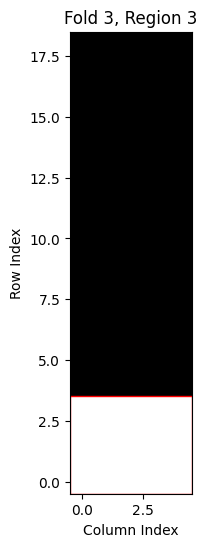

In [8]:
fold_rectangles = best_config.generate_fold_rectangles(combine_subregions=False)

In [9]:
fold_meshes = crop_meshes_per_fold(
    dh.extracted_meshes,
    fold_rectangles,
    best_config.x_edges,
    best_config.y_edges,
)

01:29:14 - INFO - Processing Region 1 in Fold 1
01:29:25 - INFO - Processing Region 2 in Fold 2
01:29:40 - INFO - Processing Region 3 in Fold 3


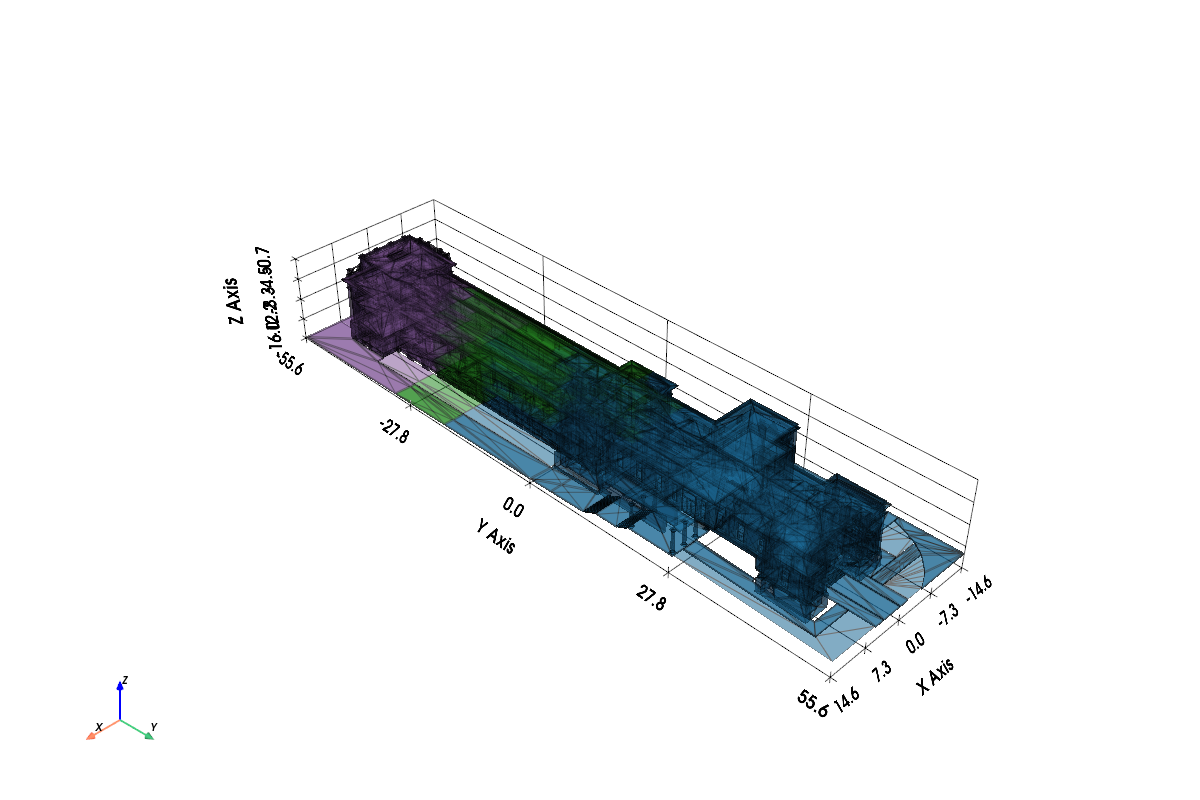

In [12]:
plot_mesh_folds(fold_meshes, backend='static', cmap='tab20')

In [13]:
best_config.save(f"../../fold_allocations/{label}_v1.pkl")

In [15]:
save_fold_meshes(dh, fold_meshes)

01:55:58 - INFO - Saved Fold 1, Region 1, Category '1_WALL' to ../../data/meshes/extracted/park_row/train/1_wall_sceneid1.ply.
01:55:58 - INFO - Saved Fold 1, Region 1, Category '2_FLOOR' to ../../data/meshes/extracted/park_row/train/2_floor_sceneid1.ply.
01:55:58 - INFO - Saved Fold 1, Region 1, Category '3_ROOF' to ../../data/meshes/extracted/park_row/train/3_roof_sceneid1.ply.
01:55:58 - INFO - Saved Fold 1, Region 1, Category '4_CEILING' to ../../data/meshes/extracted/park_row/train/4_ceiling_sceneid1.ply.
01:55:58 - INFO - Saved Fold 1, Region 1, Category '5_FOOTPATH' to ../../data/meshes/extracted/park_row/train/5_footpath_sceneid1.ply.
01:55:58 - INFO - Saved Fold 1, Region 1, Category '6_GRASS' to ../../data/meshes/extracted/park_row/train/6_grass_sceneid1.ply.
01:55:58 - INFO - Saved Fold 1, Region 1, Category '7_COLUMN' to ../../data/meshes/extracted/park_row/train/7_column_sceneid1.ply.
01:55:58 - INFO - Saved Fold 1, Region 1, Category '8_DOOR' to ../../data/meshes/extracte